<a href="https://colab.research.google.com/github/MunySafitri/Pemrosesan-Citra-Digital/blob/main/MunySafitri_Assignment01_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline

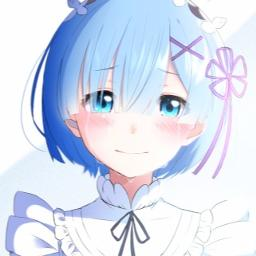

In [6]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/img/asal.jpg')
cv2_imshow(image)

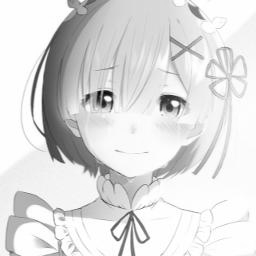

In [7]:
image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
cv2_imshow(image)

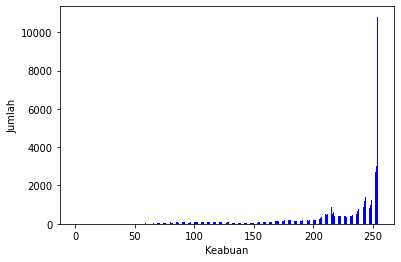

In [8]:
# NO 1 (HISTOGRAM DARI IMAGE) #cara ke satu
grayimg = image.astype(int)
keabuan = np.zeros(256,dtype=int)
r = np.zeros(256,dtype=int)
for x in range (256):
    r[x] = x
tinggi, lebar = grayimg.shape
n = tinggi*lebar
for i in range(tinggi):
    for j in range (lebar):
        keabuan[ grayimg[i,j] ] += 1
plt.xlabel('Keabuan')
plt.ylabel('Jumlah')
plt.bar(r, keabuan,color ='blue', width = 0.5)
plt.show()

In [9]:
import numpy as np
import scipy.integrate as integrate


In [10]:
def normal_dist(x, mean=0.0, vari=1.0):
    """A normal distribution function created to use with scipy.integral.quad
    """
    return (1.0/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))


In [11]:
def expected_normal_dist(x, mean=0.0, vari=1.0):
    """A expected value of normal distribution function which created to use with scipy.integral.quad
    """
    return (x/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))


In [12]:
def laplace_dist(x, mean=0.0, vari=1.0):
    """ A laplace distribution function to use with scipy.integral.quad
    """
    #In laplace distribution beta is used instead of variance so, the converting is necessary.
    scale = np.sqrt(vari/2.0)
    return (1.0/(2.0*scale))*np.exp(-(np.abs(x-mean))/(scale))


In [13]:
def expected_laplace_dist(x, mean=0.0, vari=1.0):
    """A expected value of laplace distribution function which created to use with scipy.integral.quad
    """
    scale = np.sqrt(vari/2.0)
    return x*(1.0/(2.0*scale))*np.exp(-(np.abs(x-mean))/(scale))

#def variance(x, mean=0.0, std=1.0):
#    """
#    create normal distribution 
#    """
#    return (1.0/(std*np.sqrt(2.0*np.pi)))*np.power(x-mean,2)*np.exp((-np.power((x-mean),2.0)/(2.0*np.power(std,2.0))))


In [14]:
def MSE_loss(x, x_hat_q):
    """Find the mean square loss between x (orginal signal) and x_hat (quantized signal)
    Args:
        x: the signal without quantization
        x_hat_q: the signal of x after quantization
    Return:
        MSE: mean square loss between x and x_hat_q
    """
    #protech in case of input as tuple and list for using with numpy operation
    x = np.array(x)
    x_hat_q = np.array(x_hat_q)
    assert np.size(x) == np.size(x_hat_q)
    MSE = np.sum(np.power(x-x_hat_q,2))/np.size(x)
    return MSE


In [21]:
class LloydMaxQuantizer(object):
    """A class for iterative Lloyd Max quantizer.
    This quantizer is created to minimize amount SNR between the orginal signal
    and quantized signal.
    """
    @staticmethod
    def start_repre(x, bit):
        """
        Generate representations of each threshold using 
        Args:
            x: input signal for
            bit: amount of bit
        Return:
            threshold:
        """
        assert isinstance(bit, int)
        x = np.array(x)
        num_repre  = np.power(2,bit)
        step = (np.max(x)-np.min(x))/num_repre
        
        middle_point = np.mean(x)
        repre = np.array([])
        for i in range(int(num_repre/2)):
             repre = np.append(repre, middle_point+(i+1)*step)
             repre = np.insert(repre, 0, middle_point-(i+1)*step)
        return repre

    @staticmethod
    def threshold(repre):
        """
        """
        t_q = np.zeros(np.size(repre)-1)
        for i in range(len(repre)-1):
            t_q[i] = 0.5*(repre[i]+repre[i+1])
        return t_q
    
    @staticmethod
    def represent(thre, expected_dist, dist):
        """
        """
        thre = np.array(thre)
        x_hat_q = np.zeros(np.size(thre)+1)
        #prepare for all possible integration range
        thre = np.append(thre, np.inf)
        thre = np.insert(thre, 0, -np.inf)
    
        for i in range(len(thre)-1):
             x_hat_q[i] = integrate.quad(expected_dist, thre[i], thre[i+1])[0]/(integrate.quad(dist,thre[i],thre[i+1])[0])
        return x_hat_q
    
    @staticmethod
    def quant(x, thre, repre):
        """Quantization operation. 
        """
        thre = np.append(thre, np.inf)
        thre = np.insert(thre, 0, -np.inf)
        x_hat_q = np.zeros(np.shape(x))
        for i in range(len(thre)-1):
            if i == 0:
                x_hat_q = np.where(np.logical_and(x > thre[i], x <= thre[i+1]),
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
            elif i == range(len(thre))[-1]-1:
                x_hat_q = np.where(np.logical_and(x > thre[i], x <= thre[i+1]), 
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
            else:
                x_hat_q = np.where(np.logical_and(x > thre[i], x < thre[i+1]), 
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
        return x_hat_q

In [18]:
try: import matplotlib.pyplot as plt
except ModuleNotFoundError:
    import matplotlib
    matplotlib.use('agg')
    import matplotlib.pyplot as plt
import numpy as np
import argparse, os

In [19]:
# parser = argparse.ArgumentParser(description='lloyd-max iteration quantizer')
# parser.add_argument('--bit', '-b', type=int, default=8, help='number of bit for quantization')
# parser.add_argument('--iteration', '-i', type=int, default=1_000_000, help='number of iteration')
# parser.add_argument('--range', '-r', type=int, default=10, help='range of the initial distribution')
# parser.add_argument('--resolution', '-re', type=int, default=100, help='resolution of the initial distribution')
# parser.add_argument('--save_location', '-s', type=str, default='outputs', help='save location of representations and ')

_StoreAction(option_strings=['--save_location', '-s'], dest='save_location', nargs=None, const=None, default='outputs', type=<class 'str'>, choices=None, help='save location of representations and ', metavar=None)

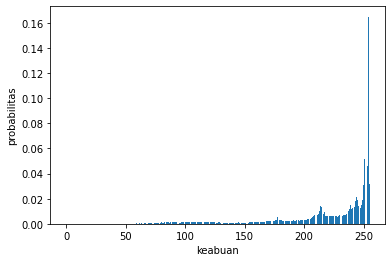

In [48]:
pr = keabuan/n
plt.xlabel('keabuan')
plt.ylabel('probabilitas')
plt.bar(r, pr)
plt.show()


In [50]:
print(type(pr))
x = pr#nilai array
print(pr)
repre = LloydMaxQuantizer.start_repre(x, 8)#8 bit
min_loss = 1.0 

<class 'numpy.ndarray'>
[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.05175781e-05
 1.52587891e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.52587891e-05
 3.05175781e-05 1.52587891e-05 1.52587891e-05 0.00000000e+00
 1.52587891e-05 0.00000000e+00 1.52587891e-05 1.52587891e-05
 1.52587891e-05 4.57763672e-05 1.52587891e-05 1.52587891e-05
 3.05175781e-05 4.57763672e-05 1.52587891e-05 4.57763672e-05
 1.52587891e-05 6.10351562e-05 0.00000000e+00 4.57763672e-05
 6.10351562e-05 1.52587891e-05 3.05175781e-05 4.57763672e-05
 0.00000000e+00 4.57763672e-05 3.05175781e-05 3.05175781e-05
 4.57763672e-05 0.00000000e+00 4.57763672e-05 4.57763672e-05
 4.57763672e-05 1.06811523e-04 6.10351562e-05 6.10351562e-05
 7.62939453e-05 4.57763672e-05 7.62939453e-05 1.06811523e-04
 1.06811523e-04 7.62939453e-05 7.62939453e-05 1.22070312e-04
 7.62939453e-05 1.22070312e-04 1.67846680e-04 2.44140625e-04
 2.13623047e-04 2.28881836e-04 2.59399414e-04 2.44140625e-04


In [51]:
for i in range(100):
        thre = LloydMaxQuantizer.threshold(repre)
        #In case wanting to use with another mean or variance, need to change mean and variance in untils.py file
        repre = LloydMaxQuantizer.represent(thre, expected_normal_dist, normal_dist)
        x_hat_q = LloydMaxQuantizer.quant(x, thre, repre)
        loss = MSE_loss(x, x_hat_q)

        # Print every 10 loops
        if(i%10 == 0 and i != 0):
            print('iteration: ' + str(i))
            print('thre: ' + str(thre))
            print('repre: ' + str(repre))
            print('loss: ' + str(loss))
            print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

        # Keep the threhold and representation that has the lowest MSE loss.
        if(min_loss > loss):
            min_loss = loss
            min_thre = thre
            min_repre = repre

iteration: 10
thre: [-1.41111083e+00 -7.66393799e-01 -3.99785921e-01 -2.06015860e-01
 -1.18772847e-01 -8.64932430e-02 -7.67336063e-02 -7.40982713e-02
 -7.31440824e-02 -7.24690094e-02 -7.18230655e-02 -7.11785607e-02
 -7.05340559e-02 -6.98895511e-02 -6.92450462e-02 -6.86005414e-02
 -6.79560366e-02 -6.73115318e-02 -6.66670270e-02 -6.60225222e-02
 -6.53780174e-02 -6.47335126e-02 -6.40890078e-02 -6.34445030e-02
 -6.27999982e-02 -6.21554934e-02 -6.15109886e-02 -6.08664838e-02
 -6.02219790e-02 -5.95774742e-02 -5.89329694e-02 -5.82884646e-02
 -5.76439598e-02 -5.69994550e-02 -5.63549502e-02 -5.57104454e-02
 -5.50659406e-02 -5.44214358e-02 -5.37769310e-02 -5.31324262e-02
 -5.24879214e-02 -5.18434166e-02 -5.11989118e-02 -5.05544070e-02
 -4.99099022e-02 -4.92653974e-02 -4.86208926e-02 -4.79763878e-02
 -4.73318830e-02 -4.66873782e-02 -4.60428734e-02 -4.53983686e-02
 -4.47538638e-02 -4.41093590e-02 -4.34648542e-02 -4.28203494e-02
 -4.21758446e-02 -4.15313398e-02 -4.08868350e-02 -4.02423302e-02
 -3.9

In [52]:
print('min loss' + str(min_loss))
print('min thre' + str(min_thre))
print('min repre' + str(min_repre))

min loss3.0795532059717004e-08
min thre[-1.91133911e+00 -1.30656419e+00 -9.02034004e-01 -6.13871466e-01
 -4.10620132e-01 -2.72844105e-01 -1.84450003e-01 -1.31187444e-01
 -1.01127324e-01 -8.52022410e-02 -7.72008198e-02 -7.32815980e-02
 -7.12930116e-02 -7.01413297e-02 -6.93214804e-02 -6.86216533e-02
 -6.79612935e-02 -6.73126839e-02 -6.66672256e-02 -6.60225237e-02
 -6.53779833e-02 -6.47334732e-02 -6.40889680e-02 -6.34444635e-02
 -6.27999591e-02 -6.21554547e-02 -6.15109503e-02 -6.08664459e-02
 -6.02219415e-02 -5.95774371e-02 -5.89329327e-02 -5.82884283e-02
 -5.76439239e-02 -5.69994195e-02 -5.63549151e-02 -5.57104107e-02
 -5.50659063e-02 -5.44214019e-02 -5.37768975e-02 -5.31323931e-02
 -5.24878887e-02 -5.18433843e-02 -5.11988799e-02 -5.05543755e-02
 -4.99098711e-02 -4.92653667e-02 -4.86208623e-02 -4.79763579e-02
 -4.73318535e-02 -4.66873491e-02 -4.60428447e-02 -4.53983403e-02
 -4.47538359e-02 -4.41093315e-02 -4.34648271e-02 -4.28203227e-02
 -4.21758183e-02 -4.15313139e-02 -4.08868095e-02 -4

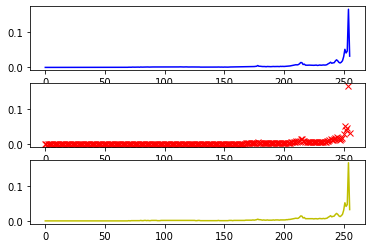

In [53]:
#x_hat_q with the lowest amount of loss.
best_x_hat_q = LloydMaxQuantizer.quant(x, min_thre, min_repre)
fig = plt.figure()
ax = fig.add_subplot(3,1,1)
ax.plot(range(np.size(x)), x, 'b')
ax = fig.add_subplot(3,1,2)
ax.plot(range(np.size(best_x_hat_q)), best_x_hat_q, 'rx')
ax = fig.add_subplot(3,1,3)
ax.plot(range(np.size(best_x_hat_q)), best_x_hat_q, 'y')
plt.show()

In [58]:
print(repre[1])

-2.1747031402386425


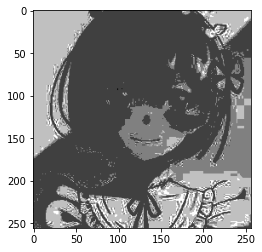

In [59]:
result = np.zeros(grayimg.shape, dtype=int)
tinggi, lebar = grayimg.shape
n = tinggi*lebar
for i in range (tinggi):
    for j in range (lebar):
        result[i,j] = round (repre[grayimg[i,j]]) #mengganti nilai setiap pixel hasil dari map value
plt.imshow(result, cmap = 'gray')